In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


In [2]:
data =  pd.read_csv('../input/nyse/prices.csv', header=0)

In [3]:
data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
print(data.columns)
print(data.shape)

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')
(851264, 7)


In [5]:
data.iloc[:, 2:-1].describe()

,open,close,low,high
count,851264.000000,851264.000000,851264.000000,851264.000000
mean,70.836986,70.857109,70.118414,71.543476
std,83.695876,83.689686,82.877294,84.465504
min,0.850000,0.860000,0.830000,0.880000
25%,33.840000,33.849998,33.480000,34.189999
50%,52.770000,52.799999,52.230000,53.310001
75%,79.879997,79.889999,79.110001,80.610001
max,1584.439941,1578.130005,1549.939941,1600.930054


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [7]:
print(len(data['symbol'].unique()))
symbols = data['symbol'].unique()

501


In [8]:
data['symbol'].describe()

count     851264
unique       501
top          LEG
freq        1762
Name: symbol, dtype: object

In [9]:
choosen_symbol = random.choice(symbols)
print(choosen_symbol)

ZION


In [10]:
data_prices = data[data['symbol'] == choosen_symbol].reset_index(drop = True)
data_prices.iloc[:10, :]

,date,symbol,open,close,low,high,volume
0,2010-01-04,ZION,12.940000,13.330000,12.880000,13.370000,3974600.0
1,2010-01-05,ZION,13.280000,13.800000,13.230000,13.830000,5605500.0
2,2010-01-06,ZION,13.670000,15.000000,13.660000,15.010000,12615200.0
3,2010-01-07,ZION,14.970000,16.680000,14.950000,17.000000,24716800.0
4,2010-01-08,ZION,16.190001,16.410000,15.520000,16.660000,6903000.0
5,2010-01-11,ZION,16.469999,16.510000,16.100000,16.790001,5532000.0
6,2010-01-12,ZION,16.379999,16.049999,15.830000,16.940001,7340200.0
7,2010-01-13,ZION,15.950000,16.350000,15.140000,16.570000,10367200.0
8,2010-01-14,ZION,16.360001,16.709999,16.250000,16.850000,4677900.0
9,2010-01-15,ZION,16.780001,16.260000,16.120001,16.889999,4889300.0


In [11]:
data_prices = data_prices.drop(['date', 'symbol'], axis=1)

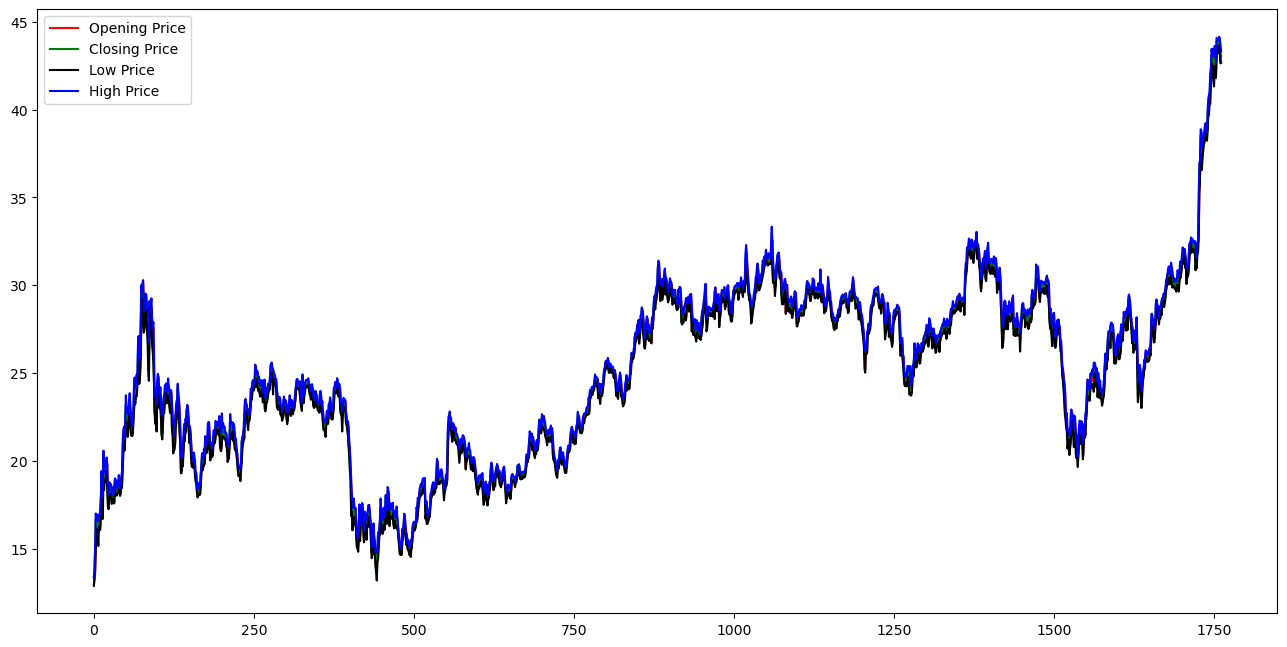

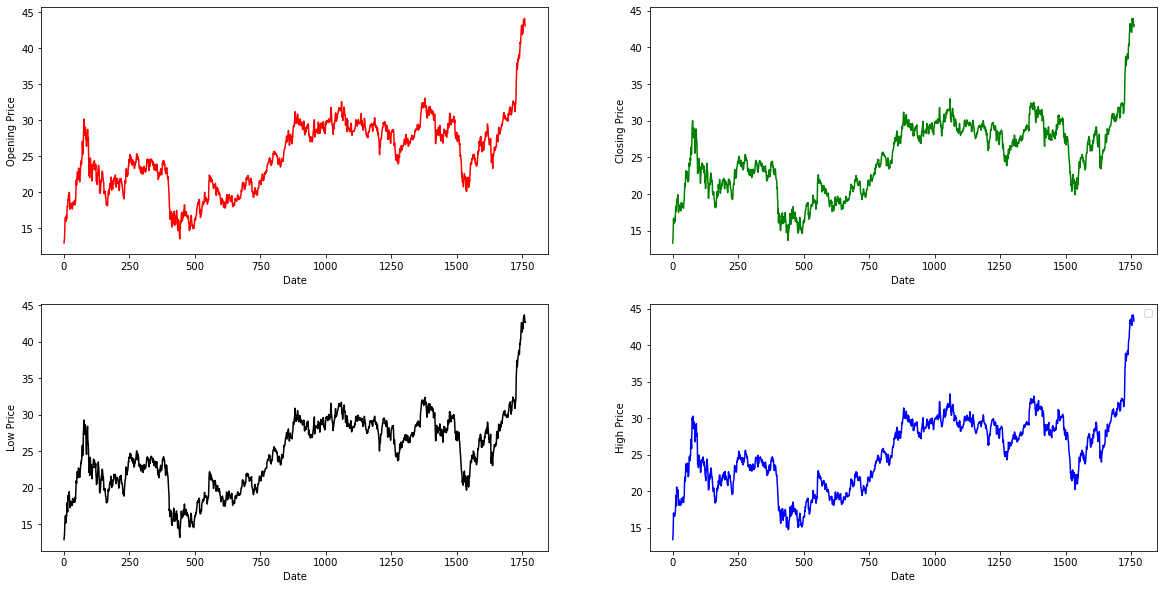

In [12]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(data_prices['open'], color='red', label = 'Opening Price')
plt.plot(data_prices['close'], color='green', label = 'Closing Price')
plt.plot(data_prices['low'], color='black', label = 'Low Price')
plt.plot(data_prices['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data_prices['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data_prices['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(data_prices['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(data_prices['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

In [13]:
data_prices = data_prices.drop(['close', 'low', 'high'], axis=1)

In [14]:
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)

In [15]:
data_prices_scaled.shape

(1762, 2)

In [16]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [18]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1390, 25, 2)
(347, 25, 2)
(1390, 1)
(347, 1)


In [19]:
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 16)            1216      
_________________________________________________________________
dropout (Dropout)            (None, 25, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________


In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
16/16 [==============================] - 1s 72ms/step - loss: 0.0515 - root_mean_squared_error: 0.2268 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 2/40
16/16 [==============================] - 0s 26ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 3/40
16/16 [==============================] - 0s 25ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 4/40
16/16 [==============================] - 0s 23ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 5/40
16/16 [==============================] - 0s 24ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 6/40
16/16 [==============================] - 0s 23ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0024 - val_root_m

In [21]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

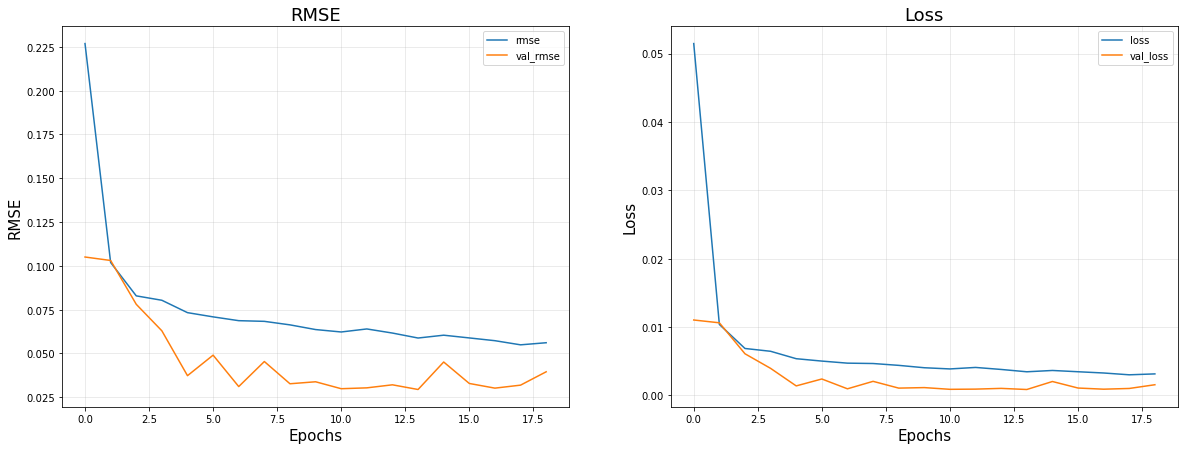

In [22]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [23]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

11/11 [==============================] - 0s 5ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597
test loss, test acc: [0.0036 0.0597]


In [24]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [25]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 00001: val_loss improved from inf to 0.00092, saving model to best_model.h5

Epoch 00002: val_loss did not improve from 0.00092

Epoch 00003: val_loss did not improve from 0.00092

Epoch 00004: val_loss improved from 0.00092 to 0.00083, saving model to best_model.h5

Epoch 00005: val_loss did not improve from 0.00083

Epoch 00006: val_loss did not improve from 0.00083

Epoch 00007: val_loss did not improve from 0.00083

Epoch 00008: val_loss did not improve from 0.00083

Epoch 00009: val_loss improved from 0.00083 to 0.00073, saving model to best_model.h5

Epoch 00010: val_loss did not improve from 0.00073

Epoch 00011: val_loss did not improve from 0.00073

Epoch 00012: val_loss

In [26]:
35

35

In [27]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
0,False,False,False,16,8,0.2,"[0.0004414462309796363, 0.021010622382164]","[0.0007963897078298032, 0.02822037786245346]"
4,False,False,False,32,16,0.2,"[0.0007326017366722226, 0.027066616341471672]","[0.0014721251791343093, 0.038368284702301025]"
1,False,False,False,16,16,0.2,"[0.0008850339218042791, 0.029749520123004913]","[0.001988322241231799, 0.04459060728549957]"
2,False,False,False,16,32,0.2,"[0.0009289496229030192, 0.030478674918413162]","[0.0021404102444648743, 0.046264566481113434]"
3,False,False,False,32,8,0.2,"[0.0010768864303827286, 0.032815948128700256]","[0.0022363036405295134, 0.04728957265615463]"
5,False,False,False,32,32,0.2,"[0.001216831966303289, 0.03488311916589737]","[0.0026075122877955437, 0.05106380581855774]"


In [28]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 8
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0597

Results After Tunning:
 Test Set RMSE: 0.0282

53.0% Improvement


In [29]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [30]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 00001: val_loss improved from inf to 0.00164, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.00164 to 0.00082, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 0.00082

Epoch 00004: val_loss did not improve from 0.00082

Epoch 00005: val_loss did not improve from 0.00082

Epoch 00006: val_loss improved from 0.00082 to 0.00067, saving model to best_model.h5

Epoch 00007: val_loss did not improve from 0.00067

Epoch 00008: val_loss did not improve from 0.00067

Epoch 00009: val_loss did not improve from 0.00067

Epoch 00010: val_loss did not improve from 0.00067

Epoch 00011: val_loss did not improve from 0.00067
Epoch 00011: early stopping


In [31]:
regressor.evaluate(X_test, y_test)

11/11 [==============================] - 0s 5ms/step - loss: 0.0025


0.0025000968016684055

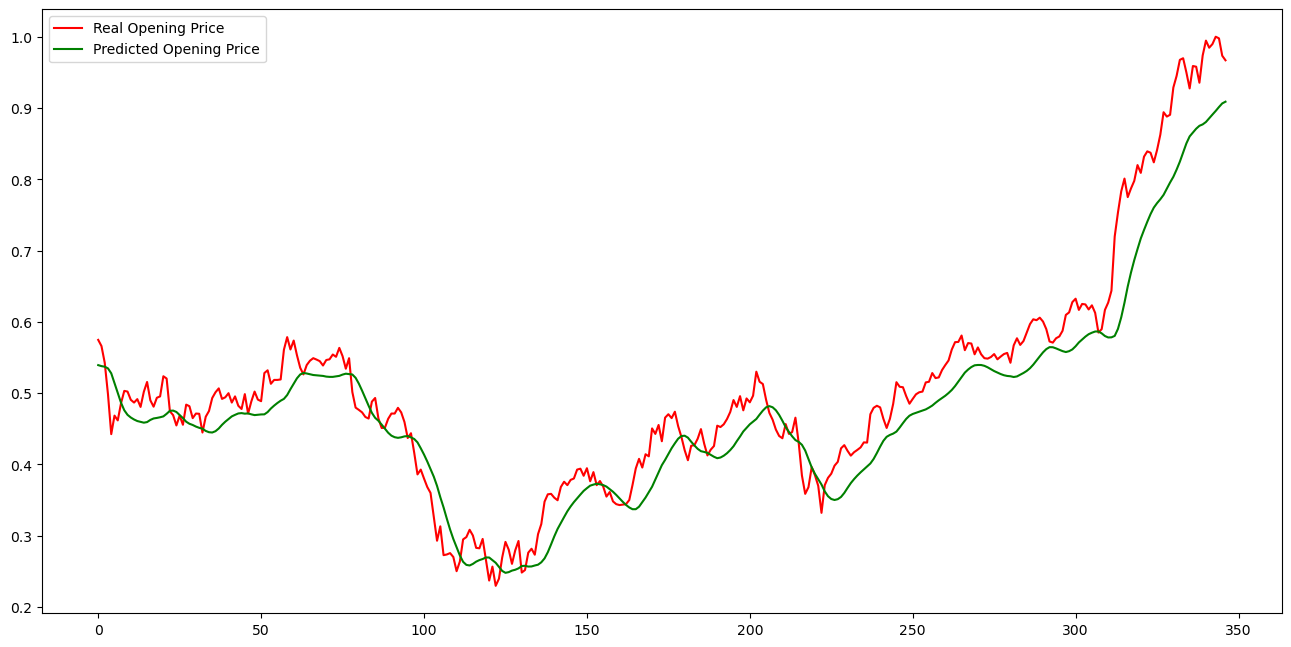

In [32]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='green', label = 'Predicted Opening Price')
plt.legend(loc='best')